# Вступление

Мы должны решить задачу бинарной классификации.
Имеем датасет с собранными историческими данными об исходах матчей между двумя командами
в некой игре. На этих данных нам необходимо натренировать модель для
предсказания победителя в будущих матчах.

**Задача**

- Необходимо предсказать исходы матчей с идентификаторами из `match_test.par`
- Наш таргет - `team_won` - номер команды победителя, может принимать значения `[0, 1]`
- Метрика оценки качества модели - ROC-AUC

# Импорт данных/библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, accuracy_score, \
precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import warnings
warnings.filterwarnings("ignore")

import shap

sns.set_theme(style="whitegrid")

# Фиксируем random-state
RAND=10

In [2]:
# Импортируем данные

team_features = pd.read_parquet('team_features.par', engine='pyarrow')
match_train = pd.read_parquet('match_train.par', engine='pyarrow')
match_test = pd.read_parquet('match_test.par', engine='pyarrow')
match_events = pd.read_parquet('match_events.par', engine='pyarrow')

# Первый взгляд на данные

In [3]:
# отобразим все столбцы в таблице

pd.set_option('display.max_columns', None)

In [4]:
team_features.tail(5)

,mid,times,team0_f0_sum,team0_f0_mean,team0_f0_min,team0_f0_max,team0_f1_sum,team0_f1_mean,team0_f1_min,team0_f1_max,team0_f2_sum,team0_f2_mean,team0_f2_min,team0_f2_max,team1_f0_sum,team1_f0_mean,team1_f0_min,team1_f0_max,team1_f1_sum,team1_f1_mean,team1_f1_min,team1_f1_max,team1_f2_sum,team1_f2_mean,team1_f2_min,team1_f2_max
499475,49947,360,14395,2879.0,1356,4493,90,18.0,4,27,8875,1775.0,708,2649,10712,2142.4,1236,2850,85,17.0,4,21,9597,1919.4,858,2759
499476,49947,420,16924,3384.8,1854,5259,117,23.4,7,35,10880,2176.0,1153,3081,12662,2532.4,1449,3345,109,21.8,5,27,11080,2216.0,906,3259
499477,49947,480,19015,3803.0,2005,6313,136,27.2,7,46,12196,2439.2,1152,3539,15180,3036.0,1600,3865,127,25.4,5,34,13068,2613.6,1029,3911
499478,49947,540,22161,4432.2,2155,7999,156,31.2,8,61,14728,2945.6,1168,5034,17661,3532.2,2271,4513,144,28.8,5,42,14685,2937.0,1217,4116
499479,49947,600,25107,5021.4,2655,9069,170,34.0,10,65,16635,3327.0,1602,5437,19727,3945.4,2421,4969,167,33.4,5,48,16231,3246.2,1489,4616


In [5]:
team_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499480 entries, 0 to 499479
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   mid            499480 non-null  int64  
 1   times          499480 non-null  int64  
 2   team0_f0_sum   499480 non-null  int64  
 3   team0_f0_mean  499480 non-null  float64
 4   team0_f0_min   499480 non-null  int64  
 5   team0_f0_max   499480 non-null  int64  
 6   team0_f1_sum   499480 non-null  int64  
 7   team0_f1_mean  499480 non-null  float64
 8   team0_f1_min   499480 non-null  int64  
 9   team0_f1_max   499480 non-null  int64  
 10  team0_f2_sum   499480 non-null  int64  
 11  team0_f2_mean  499480 non-null  float64
 12  team0_f2_min   499480 non-null  int64  
 13  team0_f2_max   499480 non-null  int64  
 14  team1_f0_sum   499480 non-null  int64  
 15  team1_f0_mean  499480 non-null  float64
 16  team1_f0_min   499480 non-null  int64  
 17  team1_f0_max   499480 non-nul

In [6]:
match_train.head()

,mid,team_won
0,20348,1
1,1305,0
2,11021,0
3,1402,0
4,28962,1


In [7]:
match_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17481 entries, 0 to 17480
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   mid       17481 non-null  int64
 1   team_won  17481 non-null  int64
dtypes: int64(2)
memory usage: 273.3 KB


In [8]:
match_events.head()

,mid,event_type,from_team,time
0,0,3,0,1
1,1,3,0,222
2,2,3,1,143
3,3,3,0,143
4,4,3,1,53


In [9]:
match_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69120 entries, 0 to 69119
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   mid         69120 non-null  int64
 1   event_type  69120 non-null  int64
 2   from_team   69120 non-null  int64
 3   time        69120 non-null  int64
dtypes: int64(4)
memory usage: 2.1 MB


In [10]:
team_features.describe()

,mid,times,team0_f0_sum,team0_f0_mean,team0_f0_min,team0_f0_max,team0_f1_sum,team0_f1_mean,team0_f1_min,team0_f1_max,team0_f2_sum,team0_f2_mean,team0_f2_min,team0_f2_max,team1_f0_sum,team1_f0_mean,team1_f0_min,team1_f0_max,team1_f1_sum,team1_f1_mean,team1_f1_min,team1_f1_max,team1_f2_sum,team1_f2_mean,team1_f2_min,team1_f2_max
count,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000,499480.000000
mean,24973.500000,330.000000,10597.960097,2119.592019,1325.185503,3075.044502,70.630518,14.126104,2.926538,27.300212,7803.461722,1560.692344,882.319654,2408.661772,10586.149956,2117.229991,1331.430578,3048.987251,70.853892,14.170778,3.017100,27.264547,7840.438674,1568.087735,889.181957,2394.748470
std,14418.760054,172.337052,5928.741248,1185.748250,777.655407,1753.265208,43.477488,8.695498,2.765309,17.149464,4703.148865,940.629773,634.148638,1394.481023,5901.785177,1180.357035,779.601114,1732.355744,43.573851,8.714770,2.817267,17.115525,4696.620031,939.324006,634.524045,1378.109909
min,0.000000,60.000000,1321.000000,264.200000,168.000000,285.000000,5.000000,1.000000,1.000000,1.000000,55.000000,11.000000,10.000000,11.000000,1378.000000,275.600000,143.000000,285.000000,5.000000,1.000000,1.000000,1.000000,89.000000,17.800000,10.000000,45.000000
25%,12486.750000,180.000000,5498.000000,1099.600000,661.000000,1599.000000,34.000000,6.800000,1.000000,13.000000,3734.000000,746.800000,342.000000,1227.000000,5509.000000,1101.800000,666.000000,1589.000000,34.000000,6.800000,1.000000,13.000000,3772.000000,754.400000,349.000000,1228.000000
50%,24973.500000,330.000000,10102.000000,2020.400000,1221.000000,2893.000000,66.000000,13.200000,2.000000,26.000000,7587.000000,1517.400000,796.000000,2350.000000,10101.000000,2020.200000,1227.000000,2876.000000,66.000000,13.200000,2.000000,26.000000,7634.000000,1526.800000,803.000000,2343.000000
75%,37460.250000,480.000000,15243.000000,3048.600000,1863.000000,4351.000000,102.000000,20.400000,4.000000,39.000000,11628.000000,2325.600000,1331.000000,3490.000000,15217.000000,3043.400000,1870.000000,4316.000000,102.000000,20.400000,4.000000,39.000000,11665.000000,2333.000000,1338.000000,3468.000000
max,49947.000000,600.000000,47074.000000,9414.800000,7102.000000,16572.000000,267.000000,53.400000,32.000000,131.000000,27183.000000,5436.600000,3808.000000,8858.000000,55100.000000,11020.000000,7073.000000,18518.000000,269.000000,53.800000,34.000000,127.000000,23786.000000,4757.200000,3833.000000,8166.000000


In [11]:
match_train.describe()

,mid,team_won
count,17481.000000,17481.000000
mean,24951.310108,0.482982
std,14379.711162,0.499725
min,0.000000,0.000000
25%,12601.000000,0.000000
50%,24826.000000,0.000000
75%,37449.000000,1.000000
max,49946.000000,1.000000


In [12]:
match_events.describe()

,mid,event_type,from_team,time
count,69120.000000,69120.000000,69120.000000,69120.000000
mean,24948.930237,3.743084,0.499870,214.930208
std,14418.444734,1.354570,0.500004,208.929185
min,0.000000,0.000000,0.000000,-55.000000
25%,12464.750000,3.000000,0.000000,30.000000
50%,24960.500000,3.000000,0.000000,132.000000
75%,37398.000000,5.000000,1.000000,443.000000
max,49947.000000,6.000000,1.000000,600.000000


Пропусков в данных нет

# Data Exploration

## Посомтрим на баланс классов

In [13]:
target = match_train['team_won'].value_counts()
df_new = pd.DataFrame({'labels': target.index,
                       'values': target.values
                      })

df_new.iplot(kind='pie', labels='labels', values='values', title='Распределение таргета')

Имеется небольшой дисбаланс, проигрышей в столбце таргета немного больше

## Распределение event type

In [14]:
ev_type = match_events['event_type'].value_counts()
df_new = pd.DataFrame({'labels': ev_type.index,
                       'values': ev_type.values
                      })

df_new.iplot(kind='pie', labels='labels', values='values', title='Event type')

70,6% - событие №3, 23,4% - событие №6, 6% - все остальное. Скорее всего, какие-либо нарушения во время матча

## Распределение столбца time

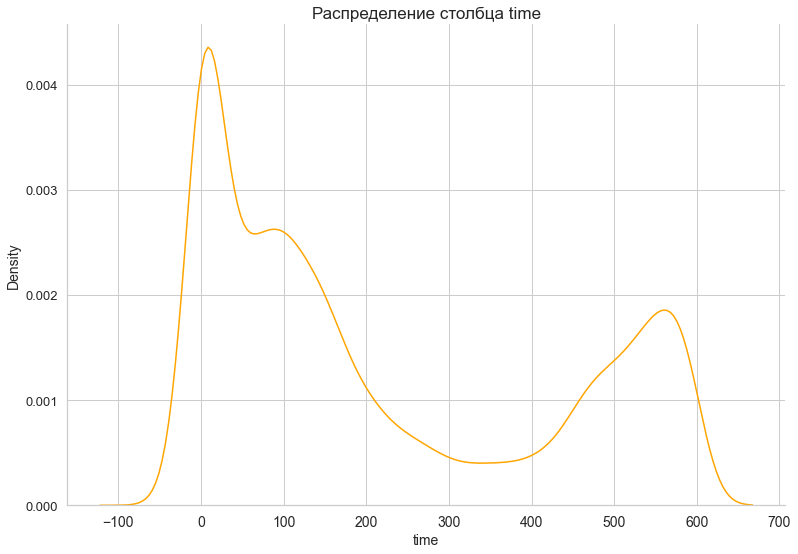

In [15]:
displot = sns.displot(x=match_events['time'], kind='kde', color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlabel('time', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Распределение столбца time', fontsize=17)

plt.show()

Есть отрицательные значения. Либо выбросы, либо какие то действия происходили до начала матча

# Поработаем с данными

## Характеристики в конце матча

In [16]:
# Возьмем характеристики в конце матча

team_features = team_features[team_features['times'] == 600]
team_features = team_features.drop(['times'], axis=1)

In [17]:
team_features

,mid,team0_f0_sum,team0_f0_mean,team0_f0_min,team0_f0_max,team0_f1_sum,team0_f1_mean,team0_f1_min,team0_f1_max,team0_f2_sum,team0_f2_mean,team0_f2_min,team0_f2_max,team1_f0_sum,team1_f0_mean,team1_f0_min,team1_f0_max,team1_f1_sum,team1_f1_mean,team1_f1_min,team1_f1_max,team1_f2_sum,team1_f2_mean,team1_f2_min,team1_f2_max
9,0,21454,4290.8,2613,5755,148,29.6,3,57,15856,3171.2,1606,4429,22095,4419.0,1725,6384,192,38.4,2,75,14930,2986.0,357,4846
19,1,22165,4433.0,2477,5760,157,31.4,5,63,15231,3046.2,1542,4810,24536,4907.2,2748,7659,144,28.8,3,49,17337,3467.4,2248,4514
29,2,21392,4278.4,1948,8581,174,34.8,6,69,18003,3600.6,1986,6234,15548,3109.6,2301,5130,99,19.8,6,56,12445,2489.0,1541,3212
39,3,20628,4125.6,2961,5464,132,26.4,1,49,15542,3108.4,1145,4640,17617,3523.4,1906,5328,143,28.6,6,51,13933,2786.6,1400,4512
49,4,18038,3607.6,2076,5154,143,28.6,4,45,15334,3066.8,1518,4855,17484,3496.8,2220,4458,101,20.2,6,37,13076,2615.2,1924,3373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499439,49943,21723,4344.6,3391,5634,155,31.0,18,52,15304,3060.8,1973,4578,24779,4955.8,2853,8245,152,30.4,3,50,17215,3443.0,1911,6009
499449,49944,19926,3985.2,2580,5610,129,25.8,1,62,14163,2832.6,1190,4117,21897,4379.4,3027,5763,134,26.8,1,58,16845,3369.0,1425,4889
499459,49945,17017,3403.4,1813,5542,125,25.0,2,67,13498,2699.6,1024,4695,18165,3633.0,2044,5997,126,25.2,2,61,13206,2641.2,1271,4448
499469,49946,19283,3856.6,3141,4405,94,18.8,2,30,14195,2839.0,2293,3612,24853,4970.6,2887,7450,172,34.4,4,72,17265,3453.0,2395,5008


## Считаем кол-во действий команд

In [18]:
# Группируем и считаем кол-во каждого действия
count_team = match_events.groupby(['mid', 'from_team'])['from_team'].count()

# Преобразуем в DF
events_count = count_team.unstack().fillna(0)

# Переименовываем
events_count = events_count.rename({0: 'team_0', 1: 'team_1'},
                                   axis=1)

# Преобразуем float в int
events_count = events_count.astype(int)

In [19]:
events_count

from_team,team_0,team_1
mid,,
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
49943,1,1
49944,0,1
49945,0,2


## Разбиваем столбец с действиями

In [20]:
# Группируем и считаем кол-во каждого действия
count_ev = match_events.groupby(['mid', 'event_type'])['event_type'].count()

# Преобразуем в DF
type_count = count_ev.unstack().fillna(0)

# Переименовываем
type_count = type_count.rename({0: 'event_0', 1: 'event_1', 2: 'event_2',
                                3: 'event_3', 4: 'event_4', 5: 'event_5',
                                6: 'event_6'}, axis=1)

# Преобразуем float в int
type_count = type_count.astype(int)

In [21]:
type_count

event_type,event_0,event_1,event_2,event_3,event_4,event_5,event_6
mid,,,,,,,
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
49943,0,0,0,1,0,0,1
49944,0,0,0,1,0,0,0
49945,0,0,0,1,0,0,1


## Преобразуем столбец с временем действий

In [22]:
# Группируем и считаем кол-во каждого действия
count_time = match_events.groupby(['mid', 'time'])['time'].count()

# Преобразуем в DF
time_count = count_time.unstack().fillna(0)

# Преобразуем float в int
time_count = time_count.astype(int)

In [23]:
time_count

time,-55,-54,-49,-48,-45,-41,-40,-39,-38,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600
mid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Обрабатываем данные

In [24]:
# Удаляем старые столбцы из таблицы
match_events = match_events.drop(['time', 'event_type', 'from_team'], axis=1)

# Удаляем дубликаты id'шников
match_events = match_events.drop_duplicates()

In [25]:
# Присоединяем к таблице

match_events = match_events.merge(events_count, left_on='mid', right_index=True)
match_events = match_events.merge(type_count, left_on='mid', right_index=True)
match_events = match_events.merge(time_count, left_on='mid', right_index=True)

In [26]:
# Соединяем все наши данные в один DF

# Для train
df_train = team_features.merge(match_events, on='mid')
df_train = df_train.merge(match_train, on='mid')

# Для test
df_test = team_features.merge(match_events, on='mid')
df_test = df_test.merge(match_test, on='mid')

In [27]:
df_train.head()

,mid,team0_f0_sum,team0_f0_mean,team0_f0_min,team0_f0_max,team0_f1_sum,team0_f1_mean,team0_f1_min,team0_f1_max,team0_f2_sum,team0_f2_mean,team0_f2_min,team0_f2_max,team1_f0_sum,team1_f0_mean,team1_f0_min,team1_f0_max,team1_f1_sum,team1_f1_mean,team1_f1_min,team1_f1_max,team1_f2_sum,team1_f2_mean,team1_f2_min,team1_f2_max,team_0,team_1,event_0,event_1,event_2,event_3,event_4,event_5,event_6,-55,-54,-49,-48,-45,-41,-40,-39,-38,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,team_won
0,0,21454,4290.8,2613,5755,148,29.6,3,57,15856,3171.2,1606,4429,22095,4419.0,1725,6384,192,38.4,2,75,14930,2986.0,357,4846,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
df_test.head()

,mid,team0_f0_sum,team0_f0_mean,team0_f0_min,team0_f0_max,team0_f1_sum,team0_f1_mean,team0_f1_min,team0_f1_max,team0_f2_sum,team0_f2_mean,team0_f2_min,team0_f2_max,team1_f0_sum,team1_f0_mean,team1_f0_min,team1_f0_max,team1_f1_sum,team1_f1_mean,team1_f1_min,team1_f1_max,team1_f2_sum,team1_f2_mean,team1_f2_min,team1_f2_max,team_0,team_1,event_0,event_1,event_2,event_3,event_4,event_5,event_6,-55,-54,-49,-48,-45,-41,-40,-39,-38,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600
0,1,22165,4433.0,2477,5760,157,31.4,5,63,15231,3046.2,1542,4810,24536,4907.2,2748,7659,144,28.8,3,49,17337,3467.4,2248,4514,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Feature Engineering

In [29]:
# Сгенерим новые фичи 'ratio' для train

# Ratio для 0-ой характеристики
df_train['mean_f0_ratio'] = df_train['team0_f0_mean'] / df_train['team1_f0_mean']
df_train['sum_f0_ratio'] = df_train['team0_f0_sum'] / df_train['team1_f0_sum']
df_train['min_f0_ratio'] = df_train['team0_f0_min'] / df_train['team1_f0_min']
df_train['max_f0_ratio'] = df_train['team0_f0_max'] / df_train['team1_f0_max']

# Ratio для 1 характеристики
df_train['mean_f1_ratio'] = df_train['team0_f1_mean'] / df_train['team1_f1_mean']
df_train['sum_f1_ratio'] = df_train['team0_f1_sum'] / df_train['team1_f1_sum']
df_train['min_f1_ratio'] = df_train['team0_f1_min'] / df_train['team1_f1_min']
df_train['max_f1_ratio'] = df_train['team0_f1_max'] / df_train['team1_f1_max']

# Ratio для 2 характеристики
df_train['mean_f2_ratio'] = df_train['team0_f2_mean'] / df_train['team1_f2_mean']
df_train['sum_f2_ratio'] = df_train['team0_f2_sum'] / df_train['team1_f2_sum']
df_train['min_f2_ratio'] = df_train['team0_f2_min'] / df_train['team1_f2_min']
df_train['max_f2_ratio'] = df_train['team0_f2_max'] / df_train['team1_f2_max']


# Сгенерим новые фичи 'ratio' для test

# Ratio для 0-ой характеристики
df_test['mean_f0_ratio'] = df_test['team0_f0_mean'] / df_test['team1_f0_mean']
df_test['sum_f0_ratio'] = df_test['team0_f0_sum'] / df_test['team1_f0_sum']
df_test['min_f0_ratio'] = df_test['team0_f0_min'] / df_test['team1_f0_min']
df_test['max_f0_ratio'] = df_test['team0_f0_max'] / df_test['team1_f0_max']

# Ratio для 1 характеристики
df_test['mean_f1_ratio'] = df_test['team0_f1_mean'] / df_test['team1_f1_mean']
df_test['sum_f1_ratio'] = df_test['team0_f1_sum'] / df_test['team1_f1_sum']
df_test['min_f1_ratio'] = df_test['team0_f1_min'] / df_test['team1_f1_min']
df_test['max_f1_ratio'] = df_test['team0_f1_max'] / df_test['team1_f1_max']

# Ratio для 2 характеристики
df_test['mean_f2_ratio'] = df_test['team0_f2_mean'] / df_test['team1_f2_mean']
df_test['sum_f2_ratio'] = df_test['team0_f2_sum'] / df_test['team1_f2_sum']
df_test['min_f2_ratio'] = df_test['team0_f2_min'] / df_test['team1_f2_min']
df_test['max_f2_ratio'] = df_test['team0_f2_max'] / df_test['team1_f2_max']

# Baseline

## Разбиваем данные на train/test

In [30]:
# Разбиваем данные на train и test

X = df_train.drop(['team_won', 'mid'], axis=1)
y = df_train.team_won

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [31]:
# DataFrame для записи результатов

metrics = pd.DataFrame(
    index=('ROC-AUC', 'F1', 'Accuracy', 'Precision', 'Recall'))

## LogisticRegression

In [32]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [33]:
# Предиктим и смотрим на метрики

y_proba = lg.predict_proba(X_test)
y_pred = lg.predict(X_test)

metrics['LogisticRegression'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7175318831027339
F1 = 0.6588716749488455
Accuracy = 0.6607558139534884
Precision = 0.6421652421652422
Recall = 0.6764705882352942


## XGBClassifier

In [34]:
# Разбиваем данные на train и test

X = df_train.drop(['team_won', 'mid'], axis=1)
y = df_train.team_won

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [35]:
# Обучаем модель

xgb = XGBClassifier(scale_pos_weight=1.07)

eval_set = [(X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=0)

[15:52:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.07, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# Предиктим и смотрим на метрики

y_proba = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

metrics['XGBClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                            f1_score(y_test, y_pred),
                            accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.6839228363273155
F1 = 0.6309628328943517
Accuracy = 0.6334302325581396
Precision = 0.615648201027984
Recall = 0.6470588235294118


## LGBMClassifier

In [37]:
# Разбиваем данные на train и test

X = df_train.drop(['team_won', 'mid'], axis=1)
y = df_train.team_won

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [38]:
# Обучаем модель

lgbm = LGBMClassifier(class_weight='balanced')

eval_set = [(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=eval_set, verbose=0)

LGBMClassifier(class_weight='balanced')

In [39]:
# Предиктим и смотрим на метрики

y_proba = lgbm.predict_proba(X_test)
y_pred = lgbm.predict(X_test)

metrics['LGBMClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                            f1_score(y_test, y_pred),
                            accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7087894909936917
F1 = 0.6515018955963838
Accuracy = 0.6526162790697675
Precision = 0.6335791264889393
Recall = 0.67046818727491


## CatBoostClassifier

In [40]:
# Разбиваем данные на train и test

X = df_train.drop(['team_won', 'mid'], axis=1)
y = df_train.team_won

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [41]:
# Обучаем модель

cat = CatBoostClassifier(verbose=False, auto_class_weights='Balanced')

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set, verbose=0)

In [42]:
# Предиктим и смотрим на метрики

y_proba = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)

metrics['CatBoostClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                            f1_score(y_test, y_pred),
                            accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7167540071270899
F1 = 0.6599307159353349
Accuracy = 0.6575581395348837
Precision = 0.635706340378198
Recall = 0.6860744297719088


# GridSearchCV

In [43]:
# Делаем поиск по сетке

parametrs = {'max_depth': [12, 8, 5],
             'learning_rate': [0.1, 0.01],
             'iterations': [500, 1000],
             'l2_leaf_reg': [0.5, 1]
            }

parametrs = {'max_depth': [5],
             'learning_rate': [0.01],
             'iterations': [1000],
             'l2_leaf_reg': [1]
            }

eval_set = [(X_test, y_test)]
grid_cv = GridSearchCV(cat, param_grid=parametrs, verbose=2, cv=3)

In [44]:
grid_cv.fit(X_train, y_train, eval_set=eval_set, verbose=0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END iterations=1000, l2_leaf_reg=1, learning_rate=0.01, max_depth=5; total time=   3.6s
[CV] END iterations=1000, l2_leaf_reg=1, learning_rate=0.01, max_depth=5; total time=   3.6s
[CV] END iterations=1000, l2_leaf_reg=1, learning_rate=0.01, max_depth=5; total time=   3.6s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fee75a1c0a0>,
             param_grid={'iterations': [1000], 'l2_leaf_reg': [1],
                         'learning_rate': [0.01], 'max_depth': [5]},
             verbose=2)

In [45]:
# Предиктим и смотрим на метрики

y_proba = grid_cv.predict_proba(X_test)
y_pred = grid_cv.predict(X_test)

metrics['GridSearchCV'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                            f1_score(y_test, y_pred),
                            accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7189932342722885
F1 = 0.6616497829232997
Accuracy = 0.6601744186046512
Precision = 0.6389044158747904
Recall = 0.6860744297719088


In [46]:
# Выводим метрики

metrics.T.style.highlight_max(color='orange', axis=0)

,ROC-AUC,F1,Accuracy,Precision,Recall
LogisticRegression,0.717532,0.658872,0.660756,0.642165,0.676471
XGBClassifier,0.683923,0.630963,0.633430,0.615648,0.647059
LGBMClassifier,0.708789,0.651502,0.652616,0.633579,0.670468
CatBoostClassifier,0.716754,0.659931,0.657558,0.635706,0.686074
GridSearchCV,0.718993,0.661650,0.660174,0.638904,0.686074


# Permutation Importance

In [47]:
# X_test на основании которого проверяем признаков

X_importance = X_test

# Создаем прогнозные значения для каждой фичи 

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_importance)

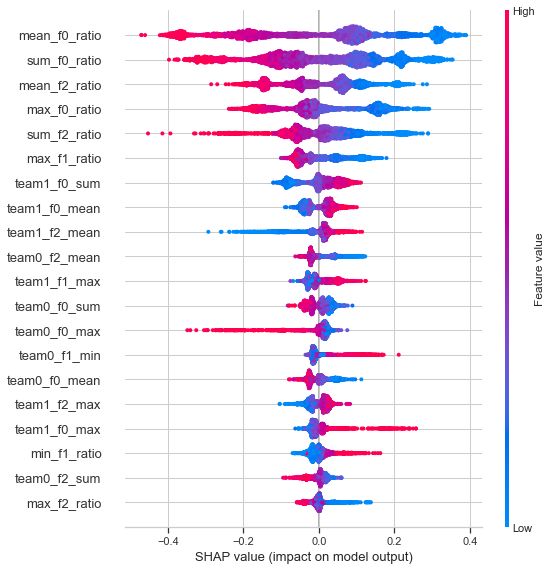

In [48]:
# Строим график

shap.summary_plot(shap_values, X_importance)

# Submission

In [49]:
ids = df_test['mid']
predict = grid_cv.predict(df_test.drop(['mid'], axis=1))

output = pd.DataFrame({'mid': ids, 'team_won': predict})
output.to_csv('submission.par', index=False)

In [50]:
output

,mid,team_won
0,1,1
1,11,0
2,28,1
3,31,0
4,35,1
...,...,...
7356,49911,0
7357,49915,0
7358,49917,0
7359,49933,0
